# Notebook Preparation

Mount Google Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [62]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, struct
import matplotlib.pyplot as plts

Start spark session

In [63]:
spark = SparkSession.builder.appName("spark_app").getOrCreate()

# File Prep

In [64]:
# Load Healthcare File

healthcare_csv_path = '/content/drive/MyDrive/my datasets/healthcare_dataset.csv'
healthcare_df = spark.read.format('csv').option('inferSchema',True).option('header',True).load(healthcare_csv_path)

In [65]:
# Show data

healthcare_df.show()

+-------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|               Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+-------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|      Bobby JacksOn| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|     Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
|       LesLie TErRy| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|            

In [66]:
# lets see the shape

shape = (healthcare_df.count(), len(healthcare_df.columns))
print(shape)

(55500, 15)


In [67]:
# lets see the schema

healthcare_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



In [68]:
# Lets make sure the name of patient is proper (CHrisTInA MARtinez should Christina Martinez)

from pyspark.sql.functions import initcap

healthcare_df = healthcare_df.withColumn('Name', initcap(col('Name')))
healthcare_df.show()


+-------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|               Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+-------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|      Bobby Jackson| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|     Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
|       Leslie Terry| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|            

Lets standardize the hospital names by removing or normalizing common suffixes like "LLC," "Ltd," "PLC," etc

In [69]:
from pyspark.sql.functions import regexp_replace, col, trim

# Define a function to clean hospital names
def clean_hospital_name(hospital_name):
    # List of common suffixes to remove
    suffixes = ['LLC', 'Ltd', 'PLC', 'Inc', 'Group', 'and']
    # Remove suffixes
    for suffix in suffixes:
        hospital_name = regexp_replace(hospital_name, r'\b' + suffix + r'\b', '')
    # Remove extra spaces and trim
    hospital_name = trim(regexp_replace(hospital_name, r'\s+', ' '))
    return hospital_name

In [70]:
# Lets apply the function

healthcare_df = healthcare_df.withColumn(
    'Hospital Name',
    clean_hospital_name(col('Hospital'))
)

In [71]:
# Lets drop Hospital column, its no longer needed

healthcare_df = healthcare_df.drop('Hospital')

In [72]:
from pyspark.sql.functions import countDistinct

# Get unique counts for each column
healthcare_df.select([countDistinct(col(c)).alias(c) for c in healthcare_df.columns]).show()

+-----+---+------+----------+-----------------+-----------------+------+------------------+--------------+-----------+--------------+--------------+----------+------------+-------------+
| Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|Doctor|Insurance Provider|Billing Amount|Room Number|Admission Type|Discharge Date|Medication|Test Results|Hospital Name|
+-----+---+------+----------+-----------------+-----------------+------+------------------+--------------+-----------+--------------+--------------+----------+------------+-------------+
|40235| 77|     2|         8|                6|             1827| 40341|                 5|         50000|        400|             3|          1856|         5|           3|        34483|
+-----+---+------+----------+-----------------+-----------------+------+------------------+--------------+-----------+--------------+--------------+----------+------------+-------------+



# Basic Queries

In [79]:
# Select Patient Name and Medication with Hospital name

q1 = healthcare_df.select('Name', 'Medication','Hospital Name').show()

+-------------------+-----------+--------------------+
|               Name| Medication|       Hospital Name|
+-------------------+-----------+--------------------+
|      Bobby Jackson|Paracetamol|         Sons Miller|
|       Leslie Terry|  Ibuprofen|                 Kim|
|        Danny Smith|    Aspirin|                Cook|
|       Andrew Watts|  Ibuprofen|Hernandez Rogers ...|
|      Adrienne Bell| Penicillin|         White-White|
|      Emily Johnson|  Ibuprofen|      Nunez-Humphrey|
|     Edward Edwards|Paracetamol|           Middleton|
| Christina Martinez|Paracetamol|Powell Robinson V...|
|    Jasmine Aguilar|    Aspirin|           Sons Rich|
|   Christopher Berg|Paracetamol|      Padilla-Walker|
|   Michelle Daniels|Paracetamol|     Schaefer-Porter|
|     Aaron Martinez|    Lipitor|         Lyons-Blair|
|      Connor Hansen| Penicillin|Powers Miller, Fl...|
|       Robert Bauer|    Lipitor|    Rivera-Gutierrez|
|       Brooke Brady|Paracetamol|     Morris-Arellano|
| Ms. Nata

In [74]:
# Select all who Paracetamol was prescribed to

q2 = healthcare_df.select('Name', 'Medical Condition','Medication').filter(healthcare_df.Medication == 'Paracetamol').show()

+-------------------+-----------------+-----------+
|               Name|Medical Condition| Medication|
+-------------------+-----------------+-----------+
|      Bobby Jackson|           Cancer|Paracetamol|
|     Edward Edwards|         Diabetes|Paracetamol|
| Christina Martinez|           Cancer|Paracetamol|
|   Christopher Berg|           Cancer|Paracetamol|
|   Michelle Daniels|           Cancer|Paracetamol|
|       Brooke Brady|           Cancer|Paracetamol|
|      Haley Perkins|        Arthritis|Paracetamol|
|Mrs. Jamie Campbell|          Obesity|Paracetamol|
|     Paul Henderson|     Hypertension|Paracetamol|
|      Joshua Oliver|     Hypertension|Paracetamol|
|      Denise Torres|         Diabetes|Paracetamol|
|      Mr. Eric Lane|           Asthma|Paracetamol|
|    Katherine Smith|          Obesity|Paracetamol|
|Christopher Chapman|     Hypertension|Paracetamol|
|        Michael Liu|     Hypertension|Paracetamol|
|Mr. David Pierce Md|     Hypertension|Paracetamol|
|      Betha

In [75]:
# Select top 10 users of Paracetamol

q3 = healthcare_df.select('Name', 'Medication','Medical Condition').filter(healthcare_df.Medication == 'Paracetamol').groupBy('Name', 'Medication','Medical Condition').count().orderBy(desc('count')).limit(10).show()

+------------------+-----------+-----------------+-----+
|              Name| Medication|Medical Condition|count|
+------------------+-----------+-----------------+-----+
|     John Williams|Paracetamol|     Hypertension|    5|
|   Stephanie Smith|Paracetamol|          Obesity|    4|
|Elizabeth Anderson|Paracetamol|        Arthritis|    4|
|     Ashley Harper|Paracetamol|          Obesity|    4|
|      John Johnson|Paracetamol|          Obesity|    4|
|   David Rodriguez|Paracetamol|        Arthritis|    3|
|      Angela Jones|Paracetamol|        Arthritis|    3|
|       Jason Lewis|Paracetamol|     Hypertension|    3|
|    Logan Gonzalez|Paracetamol|           Asthma|    3|
|       David Davis|Paracetamol|         Diabetes|    3|
+------------------+-----------+-----------------+-----+



In [76]:
# Medical condtion types

q4 = healthcare_df.select('Medical Condition').groupBy('Medical Condition').agg(count('Medical Condition').alias('Condition Occurence')).orderBy(desc('Condition Occurence'))
q4.show()

+-----------------+-------------------+
|Medical Condition|Condition Occurence|
+-----------------+-------------------+
|        Arthritis|               9308|
|         Diabetes|               9304|
|     Hypertension|               9245|
|          Obesity|               9231|
|           Cancer|               9227|
|           Asthma|               9185|
+-----------------+-------------------+



In [77]:
# Medication types

q5 = healthcare_df.select('Medication').groupBy('Medication').agg(count('Medication').alias('Medication Occurence')).orderBy(desc('Medication Occurence'))
q5.show()

+-----------+--------------------+
| Medication|Medication Occurence|
+-----------+--------------------+
|    Lipitor|               11140|
|  Ibuprofen|               11127|
|    Aspirin|               11094|
|Paracetamol|               11071|
| Penicillin|               11068|
+-----------+--------------------+



In [78]:
# Number of Male and Female

q6 = healthcare_df.select('Gender').groupBy('Gender').agg(count('Gender').alias('Gender Occurence')).orderBy(desc('Gender Occurence'))
q6.show()

+------+----------------+
|Gender|Gender Occurence|
+------+----------------+
|  Male|           27774|
|Female|           27726|
+------+----------------+



In [85]:
# Find out most used hospital by Insurance Providers

q7_a = healthcare_df.select('Insurance Provider', 'Hospital Name').groupBy('Insurance Provider', 'Hospital Name').agg(count('*').alias('Hospital Count')).orderBy('Insurance Provider')
q7_a.show()

+------------------+--------------------+--------------+
|Insurance Provider|       Hospital Name|Hospital Count|
+------------------+--------------------+--------------+
|             Aetna|           Wilkerson|             2|
|             Aetna|     Flowers-Edwards|             1|
|             Aetna|Rodriguez Glover ...|             1|
|             Aetna| Kelly Koch, Wheeler|             1|
|             Aetna|               Frank|             1|
|             Aetna|   Hicks Kidd Allen,|             1|
|             Aetna|              Warner|             3|
|             Aetna|Solis Fisher Davi...|             2|
|             Aetna|       Summers-Patel|             1|
|             Aetna|Williams Moore Br...|             1|
|             Aetna|        Barnes-Henry|             1|
|             Aetna|Fuentes, Williams...|             1|
|             Aetna|         Hanson Sons|             1|
|             Aetna|          Wang-Jones|             1|
|             Aetna|Austin, Dav

In [86]:
# Group above query by Insanrance provider, Concat Hospital Count and Hospital, and Call it Max

q7_b = q7_a.groupBy('Insurance Provider').agg(max(struct(col('Hospital Count'), col('Hospital Name'))).alias('Max'))
q7_b.show()

+------------------+-----------+
|Insurance Provider|        Max|
+------------------+-----------+
|             Aetna|{61, Smith}|
|        Blue Cross|{75, Smith}|
|             Cigna|{80, Smith}|
|          Medicare|{64, Smith}|
|  UnitedHealthcare|{66, Smith}|
+------------------+-----------+



In [87]:
# Now select only Insurance company and Hospital

q7_b = q7_a.groupBy('Insurance Provider').agg(max(struct(col('Hospital Count'), col('Hospital Name'))).alias('Max')).select('Insurance Provider', 'Max.Hospital Name')
q7_b.show()

+------------------+-------------+
|Insurance Provider|Hospital Name|
+------------------+-------------+
|             Aetna|        Smith|
|        Blue Cross|        Smith|
|             Cigna|        Smith|
|          Medicare|        Smith|
|  UnitedHealthcare|        Smith|
+------------------+-------------+



In [88]:
# How many times did patients use Aetna, Blue Cross and UnitedHealthcare

q8 = healthcare_df.select('Insurance Provider').filter(healthcare_df['Insurance Provider'].isin(['Aetna', 'Blue Cross', 'UnitedHealthcare'])).groupBy('Insurance Provider').count()
q8.show()

+------------------+-----+
|Insurance Provider|count|
+------------------+-----+
|             Aetna|10913|
|        Blue Cross|11059|
|  UnitedHealthcare|11125|
+------------------+-----+



# EDA

**01: AGE DISTRIBUTION OF PATIENTS**

In [89]:
q9 = healthcare_df.select('Age').groupBy('Age').count().orderBy('Age')
q9.show()

+---+-----+
|Age|count|
+---+-----+
| 13|   14|
| 14|   18|
| 15|   28|
| 16|   24|
| 17|   32|
| 18|  772|
| 19|  805|
| 20|  750|
| 21|  822|
| 22|  817|
| 23|  790|
| 24|  837|
| 25|  836|
| 26|  815|
| 27|  786|
| 28|  760|
| 29|  787|
| 30|  806|
| 31|  793|
| 32|  755|
+---+-----+
only showing top 20 rows



In [90]:
from pyspark.sql import functions as F

# Create age bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
q9_binned = healthcare_df.withColumn(
    "Age_Binned",
    F.when((F.col('Age') >= 0) & (F.col('Age') <= 10), "0-10")
     .when((F.col('Age') > 10) & (F.col('Age') <= 20), "11-20")
     .when((F.col('Age') > 20) & (F.col('Age') <= 30), "21-30")
     .when((F.col('Age') > 30) & (F.col('Age') <= 40), "31-40")
     .when((F.col('Age') > 40) & (F.col('Age') <= 50), "41-50")
     .when((F.col('Age') > 50) & (F.col('Age') <= 60), "51-60")
     .when((F.col('Age') > 60) & (F.col('Age') <= 70), "61-70")
     .when((F.col('Age') > 70) & (F.col('Age') <= 80), "71-80")
     .when((F.col('Age') > 80) & (F.col('Age') <= 90), "81-90")
     .otherwise("91+")
)

# Group by the new "Age_Binned" column and count the occurrences
q9_binned = q9_binned.groupBy('Age_Binned').count().orderBy('Age_Binned')
q9_binned.show()


+----------+-----+
|Age_Binned|count|
+----------+-----+
|     11-20| 2443|
|     21-30| 8056|
|     31-40| 8125|
|     41-50| 8209|
|     51-60| 8297|
|     61-70| 8228|
|     71-80| 8107|
|     81-90| 4035|
+----------+-----+



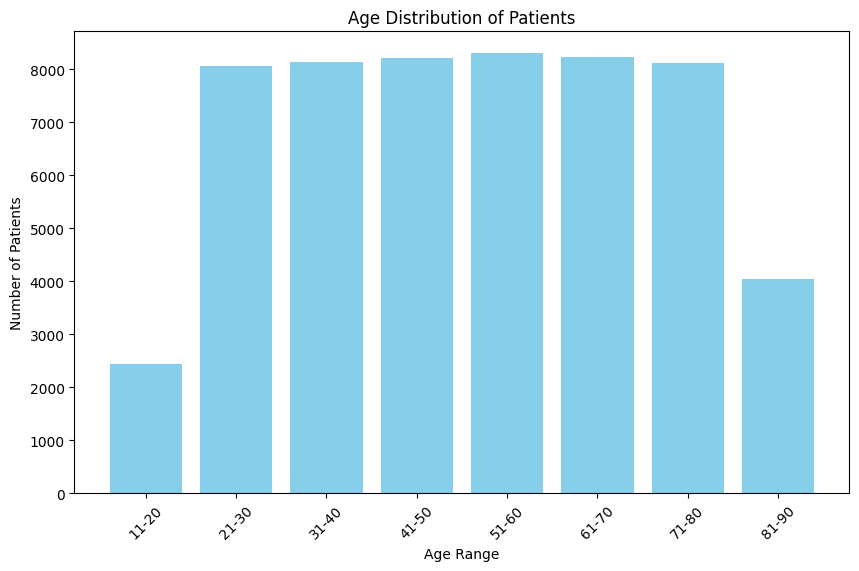

In [91]:
# Convert the grouped Spark DataFrame to Pandas for plotting
age_data = q9_binned.toPandas()

# Plot histogram using Matplotlib
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10,6))
plt.bar(age_data['Age_Binned'], age_data['count'], color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age Range')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


**Insight** - *Majority of the patients are between 51-60*

**02: WHAT IS THE FREQUENCY OF DIFFERENT MEDICAL CONDITIONS BY AGE GROUP?**

In [92]:
# Define age groups
def age_group(age):
    if age <= 20:
        return "0-20"
    elif age <= 40:
        return "21-40"
    elif age <= 60:
        return "41-60"
    else:
        return "61+"

# Register the UDF
age_group_udf = F.udf(age_group)

# Add a new column for age groups
healthcare_df = healthcare_df.withColumn("Age Group", age_group_udf(F.col("Age")))

# Show the new column
healthcare_df.select("Age", "Age Group").show()

+---+---------+
|Age|Age Group|
+---+---------+
| 30|    21-40|
| 62|      61+|
| 76|      61+|
| 28|    21-40|
| 43|    41-60|
| 36|    21-40|
| 21|    21-40|
| 20|     0-20|
| 82|      61+|
| 58|    41-60|
| 72|      61+|
| 38|    21-40|
| 75|      61+|
| 68|      61+|
| 44|    41-60|
| 46|    41-60|
| 63|      61+|
| 38|    21-40|
| 34|    21-40|
| 63|      61+|
+---+---------+
only showing top 20 rows



In [93]:
# Now, we will group the data by both the Age Group and Medical Condition columns and count how many occurrences there are for each combination.

# Group by Age Group and Medical Condition, and count occurrences
medical_condition_by_age_group = healthcare_df.groupBy("Age Group", "Medical Condition").count().orderBy("Age Group")

# Show the results
medical_condition_by_age_group.show()


+---------+-----------------+-----+
|Age Group|Medical Condition|count|
+---------+-----------------+-----+
|     0-20|        Arthritis|  428|
|     0-20|         Diabetes|  401|
|     0-20|          Obesity|  403|
|     0-20|     Hypertension|  386|
|     0-20|           Cancer|  417|
|     0-20|           Asthma|  408|
|    21-40|           Asthma| 2696|
|    21-40|        Arthritis| 2705|
|    21-40|     Hypertension| 2689|
|    21-40|           Cancer| 2695|
|    21-40|          Obesity| 2711|
|    21-40|         Diabetes| 2685|
|    41-60|           Asthma| 2654|
|    41-60|        Arthritis| 2781|
|    41-60|     Hypertension| 2743|
|    41-60|         Diabetes| 2799|
|    41-60|          Obesity| 2802|
|    41-60|           Cancer| 2727|
|      61+|     Hypertension| 3427|
|      61+|           Asthma| 3427|
+---------+-----------------+-----+
only showing top 20 rows



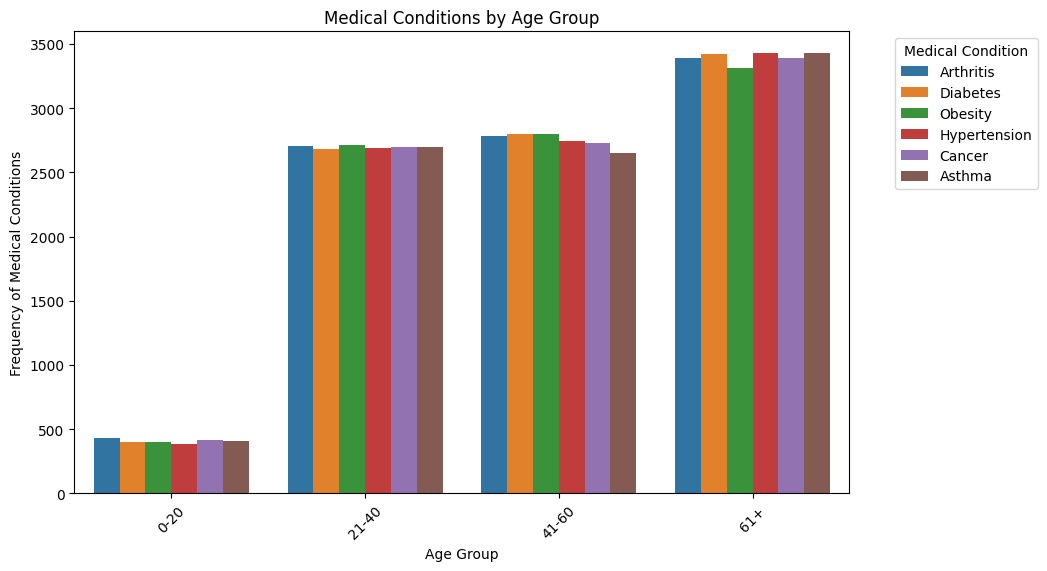

In [94]:
# Convert the Spark DataFrame to Pandas for plotting
condition_data = medical_condition_by_age_group.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot a bar chart with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=condition_data, x='Age Group', y='count', hue='Medical Condition')

# Title and labels
plt.title('Medical Conditions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Frequency of Medical Conditions')
plt.xticks(rotation=45)
plt.legend(title='Medical Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


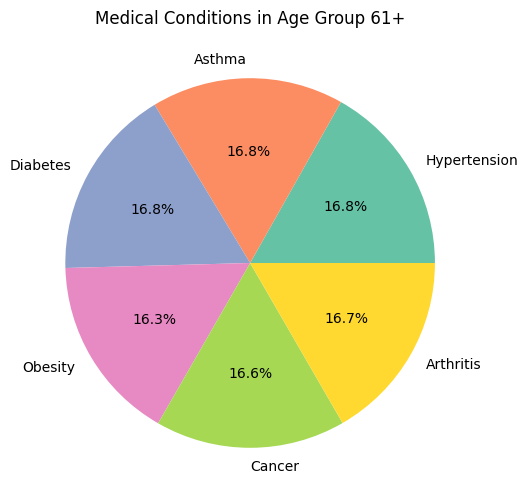

In [96]:
# Lets filter for 61+ and above, since that agr group has most medical conditions
age_group_data = condition_data[condition_data['Age Group'] == '61+']

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(age_group_data['count'], labels=age_group_data['Medical Condition'], autopct='%1.1f%%', colors=sns.color_palette("Set2", len(age_group_data)))
plt.title('Medical Conditions in Age Group 61+')
plt.show()


**Insight** - *While the conditions are closely distributed, Ages 61 and Above occuured more and Diabetes, Hypertension and Asthma occured slighly more than others.*

**03: WHAT IS THE AVERAGE BILLING AMOUNT FOR EACH MEDICAL CONDITION?**

In [97]:
# To calculate the average billing amount for different medical conditions, we need to group the data by Medical Condition and compute the average of the Billing Amount. Then, we'll visualize this data to analyze variations.

# Calculate the average billing amount for each medical condition
average_billing = healthcare_df.groupBy("Medical Condition").agg(F.avg("Billing Amount").alias("Average Billing Amount"))

# Order the results by average billing amount (optional)
average_billing = average_billing.orderBy(F.col("Average Billing Amount").desc())

# Show the results
average_billing.show()

+-----------------+----------------------+
|Medical Condition|Average Billing Amount|
+-----------------+----------------------+
|          Obesity|    25805.971259050966|
|         Diabetes|    25638.405577382244|
|           Asthma|    25635.249358698507|
|        Arthritis|    25497.327055738246|
|     Hypertension|    25497.095760788983|
|           Cancer|    25161.792707059732|
+-----------------+----------------------+



<ipython-input-102-59fbf6a2ea67>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_billing_df, x="Medical Condition", y="Average Billing Amount", palette="viridis")


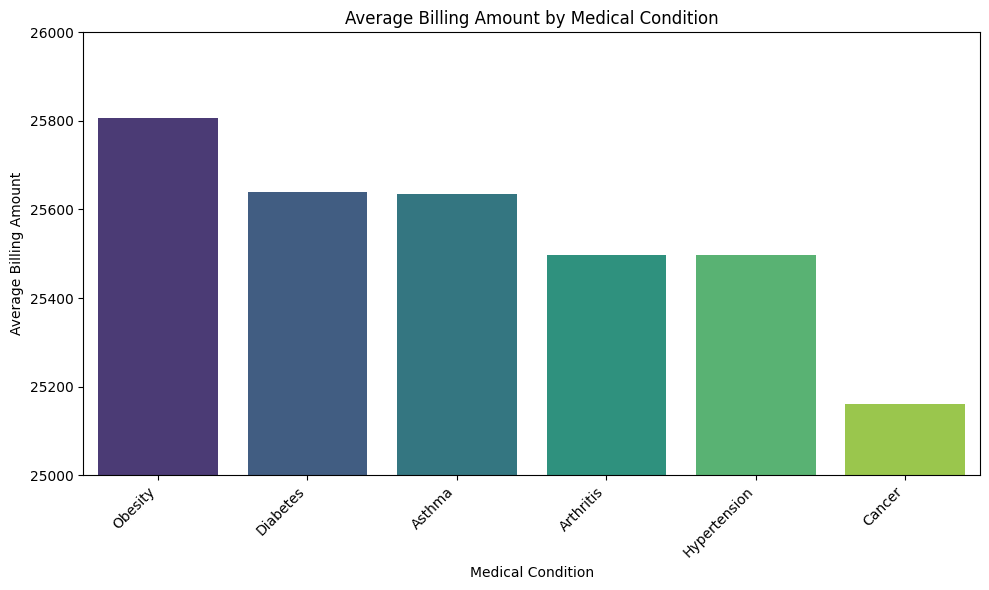

In [102]:
# Convert to Pandas DataFrame for visualization
average_billing_df = average_billing.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=average_billing_df, x="Medical Condition", y="Average Billing Amount", palette="viridis")

# Add labels and title
plt.title("Average Billing Amount by Medical Condition")
plt.xlabel("Medical Condition")
plt.ylabel("Average Billing Amount")
plt.xticks(rotation=45, ha="right")

# Set the minimum y-axis value to 25,000
plt.ylim(25000, 26000)

# Adjust layout for better visuals
plt.tight_layout()

# Show the plot
plt.show()


**Insight** - *Obesity cost more to treat on the average*

**`04: HOW LONG IS THE AVERAGE HOSPITAL STAY BASED ON ADMISSION TYPE?`**

In [103]:
# To analyze this, we'll calculate the length of stay for each patient by subtracting the Date of Admission from the Discharge Date. Then, we'll group by Admission Type to calculate the average length of stay for each type. Finally, we'll visualize the results.

from pyspark.sql.functions import col, datediff, avg

# Calculate Length of Stay
healthcare_df = healthcare_df.withColumn("Length of Stay", datediff(col("Discharge Date"), col("Date of Admission")))

# Group by Admission Type and calculate average Length of Stay
avg_stay = healthcare_df.groupBy("Admission Type").agg(avg("Length of Stay").alias("Average Length of Stay"))

# Sort the result
avg_stay = avg_stay.orderBy(col("Average Length of Stay").desc())

# Show results
avg_stay.show()


+--------------+----------------------+
|Admission Type|Average Length of Stay|
+--------------+----------------------+
|     Emergency|    15.595051726969183|
|      Elective|     15.52532833020638|
|        Urgent|    15.407999569336779|
+--------------+----------------------+



<ipython-input-106-3efc257cdc77>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_stay_df, x="Admission Type", y="Average Length of Stay", palette="coolwarm")


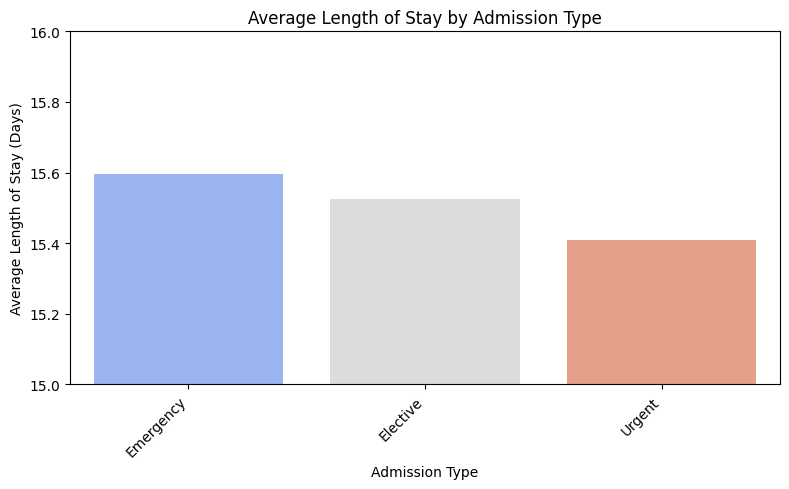

In [106]:
avg_stay_df = avg_stay.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_stay_df, x="Admission Type", y="Average Length of Stay", palette="coolwarm")

# Add labels and title
plt.title("Average Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average Length of Stay (Days)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Set the minimum y-axis value to 15
plt.ylim(15, 16)

# Adjust layout for better visuals
plt.tight_layout()

# Show the plot
plt.show()



**Insight** - *The visualization will reveal how Emergency cases tend to have the longest stays, followed by Elective cases, and finally Urgent cases. This can help hospitals plan resources, like bed availability, more efficiently based on admission types.*

**05: ANALYZING DISTRIBUTION OF INSURANCE PROVIDERS BY MEDICAL CONDITION**

In [107]:
# To answer this question, we'll calculate the frequency distribution of insurance providers for each medical condition. A heatmap or a grouped bar chart will visually highlight the involvement of insurance providers across different medical conditions.

from pyspark.sql.functions import count

# Group by Medical Condition and Insurance Provider
insurance_distribution = healthcare_df.groupBy("Medical Condition", "Insurance Provider").agg(count("*").alias("Count"))

# Pivot table
insurance_pivot = insurance_distribution.groupBy("Medical Condition").pivot("Insurance Provider").sum("Count")

# Fill null values with 0
insurance_pivot = insurance_pivot.fillna(0)

# Show the pivot table
insurance_pivot.show()


+-----------------+-----+----------+-----+--------+----------------+
|Medical Condition|Aetna|Blue Cross|Cigna|Medicare|UnitedHealthcare|
+-----------------+-----+----------+-----+--------+----------------+
|          Obesity| 1804|      1891| 1864|    1854|            1818|
|         Diabetes| 1842|      1860| 1893|    1903|            1806|
|        Arthritis| 1832|      1852| 1900|    1851|            1873|
|     Hypertension| 1876|      1813| 1821|    1847|            1888|
|           Cancer| 1819|      1808| 1864|    1866|            1870|
|           Asthma| 1740|      1835| 1907|    1833|            1870|
+-----------------+-----+----------+-----+--------+----------------+



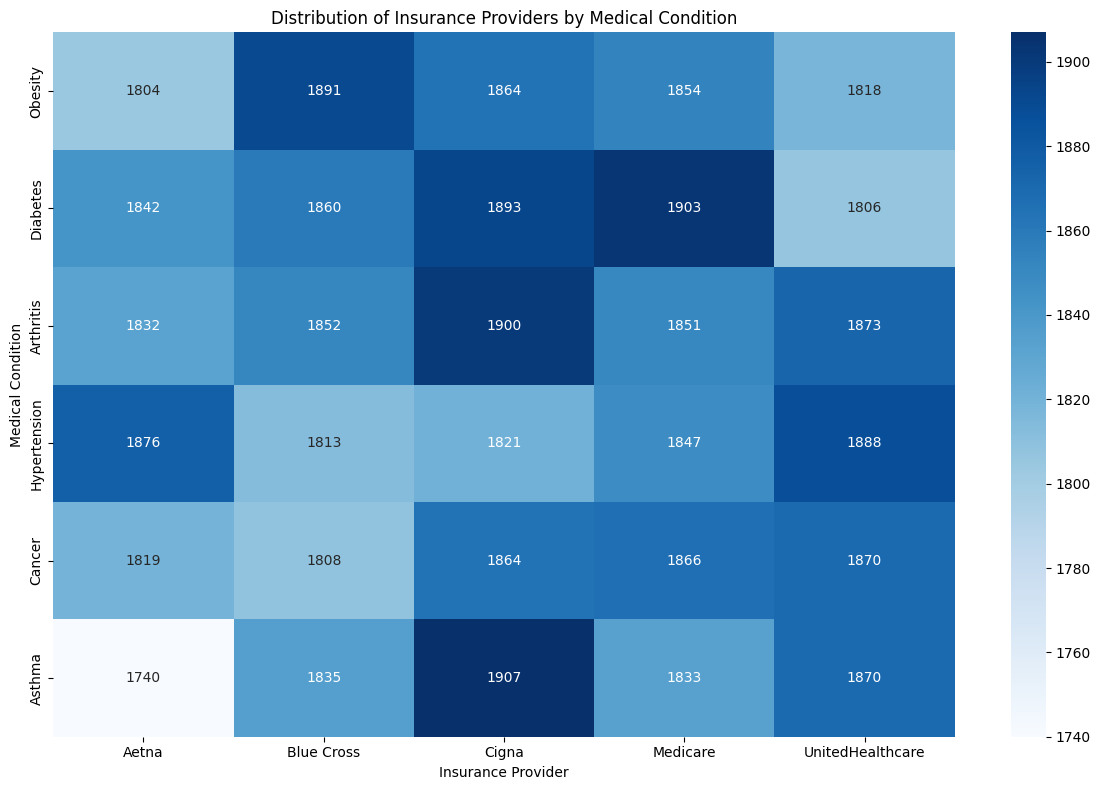

In [108]:
insurance_pivot_df = insurance_pivot.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(insurance_pivot_df.set_index("Medical Condition"), annot=True, cmap="Blues", fmt="g")

# Add labels and title
plt.title("Distribution of Insurance Providers by Medical Condition")
plt.xlabel("Insurance Provider")
plt.ylabel("Medical Condition")
plt.tight_layout()

# Show plot
plt.show()


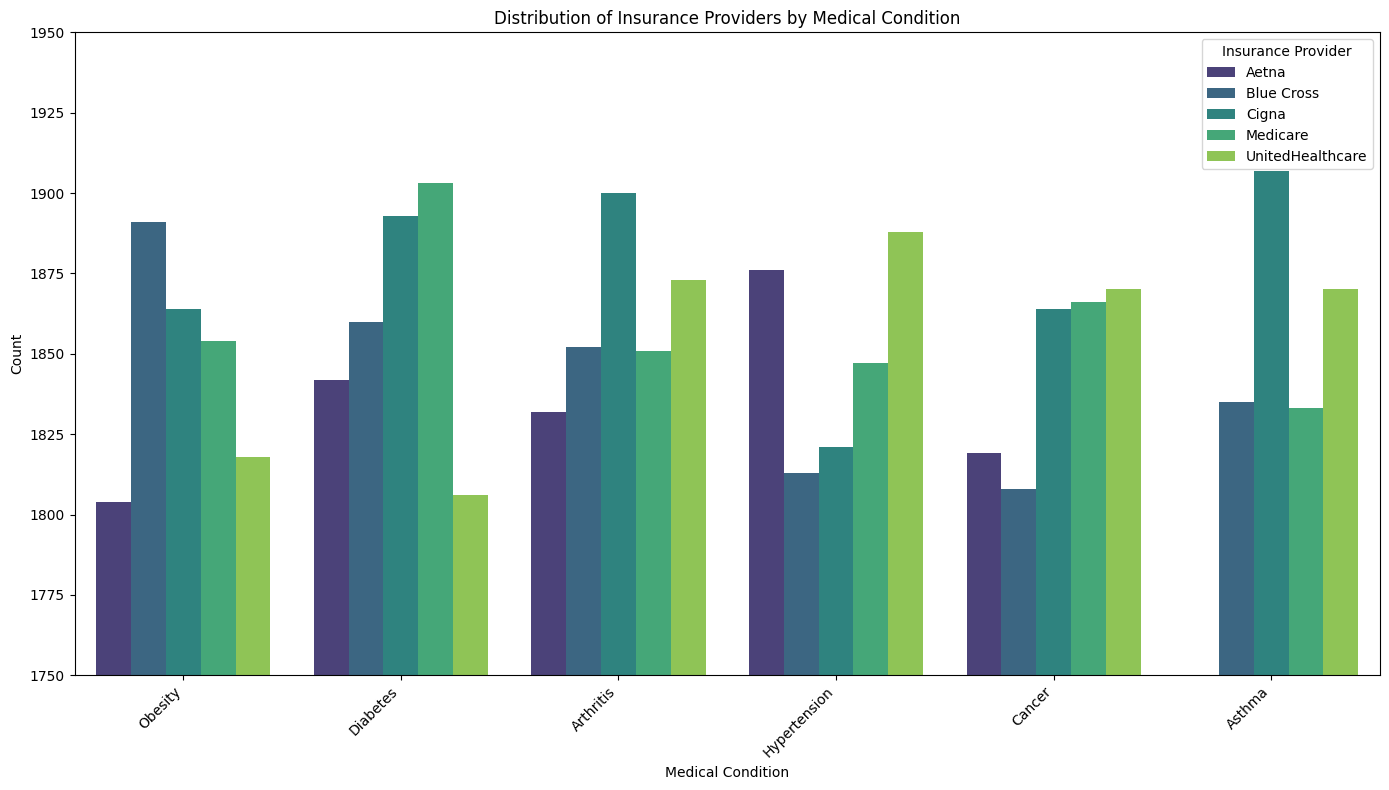

In [110]:
# Melt the data for grouped bar chart
insurance_pivot_melted = insurance_pivot_df.melt(id_vars=["Medical Condition"],
                                                 var_name="Insurance Provider",
                                                 value_name="Count")

# Create grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=insurance_pivot_melted, x="Medical Condition", y="Count", hue="Insurance Provider", palette="viridis")

# Add labels and title
plt.title("Distribution of Insurance Providers by Medical Condition")
plt.xlabel("Medical Condition")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Adjust min and max axis
plt.ylim(1750, 1950)

# Adjust layout for better visuals
plt.tight_layout()

# Show plot
plt.show()


**Insight** - *Heatmap displays the concentration of insurance providers for each medical condition. For instance, Cigna is the most common for athsma, while Aetna is least for same asthma.Grouped Bar Chart Highlights individual contributions of each provider per condition. This can inform partnerships with specific insurers based on the medical conditions they most commonly cover such as Blue cross for Obesity, Medicare for diabetes, Cigna for Arthritis, etc.*

**06: ANALYZING ADMISSION TRENDS OVER TIME**

In [112]:
# To explore admission trends, we'll analyze the number of admissions over time using the Admission Date field in the dataset. A line graph will help identify seasonal patterns, growth, or declines in admissions.

from pyspark.sql.functions import year, month, count

# Add year and month columns
admissions_trend = healthcare_df.withColumn("Year", year("Date of Admission")) \
                                .withColumn("Month", month("Date of Admission"))

# Group by year and month to count admissions
admissions_monthly = admissions_trend.groupBy("Year", "Month") \
                                     .agg(count("*").alias("Admission Count")) \
                                     .orderBy("Year", "Month")

# Show the trend data
admissions_monthly.show()


+----+-----+---------------+
|Year|Month|Admission Count|
+----+-----+---------------+
|2019|    5|            686|
|2019|    6|            907|
|2019|    7|            957|
|2019|    8|           1001|
|2019|    9|            936|
|2019|   10|           1013|
|2019|   11|            959|
|2019|   12|            928|
|2020|    1|            950|
|2020|    2|            881|
|2020|    3|            937|
|2020|    4|            924|
|2020|    5|            978|
|2020|    6|            935|
|2020|    7|           1007|
|2020|    8|           1014|
|2020|    9|            904|
|2020|   10|            962|
|2020|   11|            904|
|2020|   12|            889|
+----+-----+---------------+
only showing top 20 rows



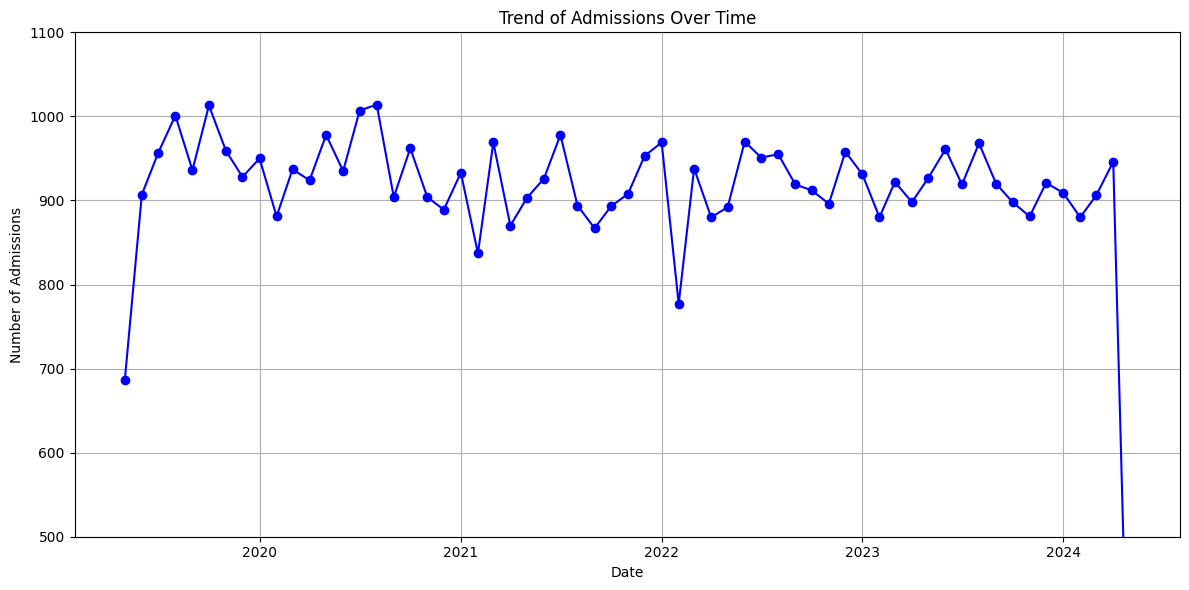

In [119]:
import pandas as pd
admissions_monthly_df = admissions_monthly.toPandas()

# Combine Year and Month into a single datetime column
admissions_monthly_df["Date"] = pd.to_datetime(admissions_monthly_df["Year"].astype(str) + "-" + admissions_monthly_df["Month"].astype(str))

import matplotlib.pyplot as plt

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(admissions_monthly_df["Date"], admissions_monthly_df["Admission Count"], marker="o", linestyle="-", color="b")

# Add labels and title
plt.title("Trend of Admissions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Admissions")
plt.grid(True)
plt.tight_layout()

# Adjust min and max axis
plt.ylim(500, 1100)

# Adjust layout for better visuals
plt.tight_layout()

# Show the plot
plt.show()


In [121]:
# Extract the month from the "Date" column to ignore the year
admissions_monthly_df["Month"] = admissions_monthly_df["Date"].dt.month

# Calculate the average admission count per month (ignoring the year)
avg_admissions_per_month = admissions_monthly_df.groupby("Month")["Admission Count"].mean().reset_index()

# Sort by average admission count in descending order
avg_admissions_per_month_sorted = avg_admissions_per_month.sort_values("Admission Count", ascending=False)

# Get the top 3 months with the highest average admissions
top_3_months = avg_admissions_per_month_sorted.head(3)

# Display the result
print(top_3_months)


   Month  Admission Count
7      8            966.4
6      7            962.4
5      6            939.8


**Insight** - *June, July and August are the months where admissions peak*

**07: WHAT IS THE TEST RESULT DISTRIBUTION ACROSS DIFFERENT CONDITIONS**

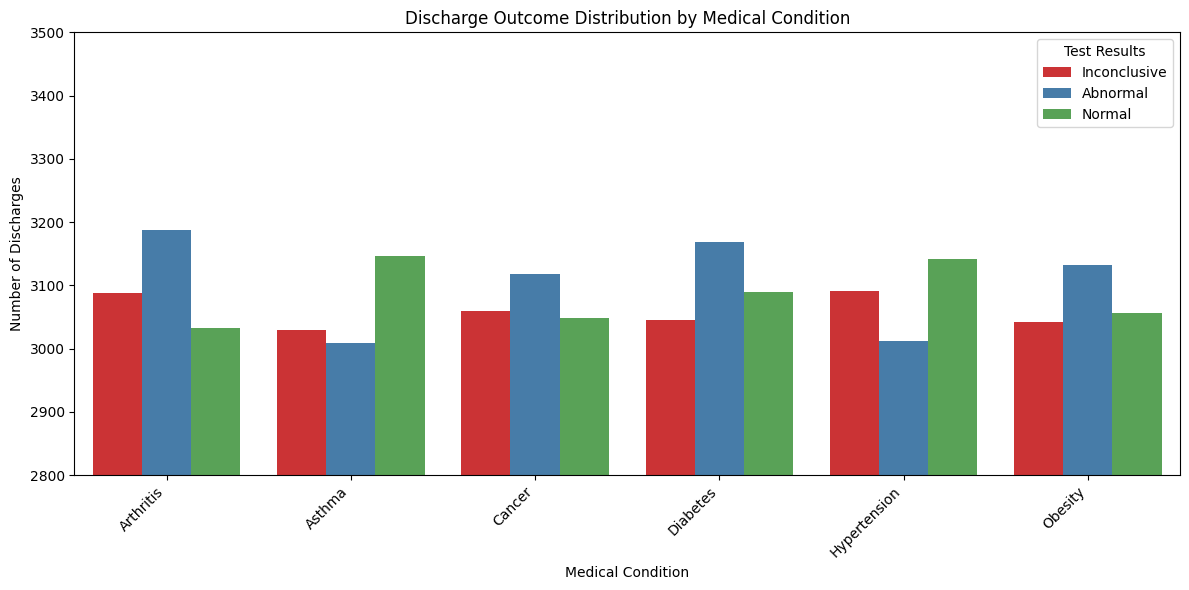

In [128]:
# To explore the distribution of discharge outcomes or Test Results across different medical conditions, we'll need to group the data by both Medical Condition and Test result, then visualize the result using a grouped bar chart.

from pyspark.sql.functions import col

# Group by Medical Condition and Discharge Outcome to count occurrences
discharge_outcome_by_condition = healthcare_df.groupBy("Medical Condition", "Test Results") \
                                              .count() \
                                              .orderBy("Medical Condition")

# Convert to Pandas for visualization
discharge_outcome_df = discharge_outcome_by_condition.toPandas()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=discharge_outcome_df, x="Medical Condition", y="count", hue="Test Results", palette="Set1")

# Add labels and title
plt.title("Test Results Distribution by Medical Condition")
plt.xlabel("Medical Condition")
plt.ylabel("Number of Discharges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Adjust min and max axis
plt.ylim(2800, 3500)

# Adjust layout for better visuals
plt.tight_layout()

# Show the plot
plt.show()


**Insight** - *Most test results are abnormal and for hypertension while majority of the results are normal and big chunck are also inconclusive* *italicized text*